## Import all libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from bkm10 import diff_cross

# First model
For a fixed set of input kinematics, predict $d^4\sigma$ as a function of $\phi$

- Define the input kinematics and CFFs and use the BKM formalism to find the differential cross section. \
Split this data into training and validation sets and normalise them as well

In [ ]:
# defining the kinematics:

k = 5.75
Q2 = 1.82000005245209
x = 0.342999994754791
t = -0.172000005841255
phi = np.linspace(0, 2*np.pi, 25) - np.pi

# defining the CFFs:

ReH = -0.992404142310346
ReHt = -0.396272488732234
ReE = -0.31
TDVCS2 = 0.017761320249214

input_cffs = tf.constant([ReH, ReHt, ReE, TDVCS2], dtype=tf.float32)

# creating a matrix of kinematics where each element is a kinematic set [[k, Q2, x, t, phi]]:
# Do this by making the fixed kinematics into vectors of shape phi and stack them column-wise

input_kins = np.column_stack(
    [np.full(phi.shape, k), np.full(phi.shape, Q2), np.full(phi.shape, x), np.full(phi.shape, t), phi])

input_kins = tf.convert_to_tensor(input_kins, dtype=tf.float32)

# compute the differential cross section for each phi.
# convert phi and dsig to normalized column vectors.

# plt.hist(dsig, bins=20, edgecolor='k')

dsig = diff_cross(input_kins, tf.expand_dims(input_cffs, axis=0))

# convert dsig to normalized column vectors
# scale dsig using MinMax as the distribution of values is U-shaped
# Scale phi using cos(phi) and sin(phi) as these will be the input angle parameters

dsig = dsig.numpy().reshape(-1, 1)
dsig_scale = MinMaxScaler().fit(dsig)
dsig = dsig_scale.transform(dsig)

phi = np.column_stack([np.cos(phi), np.sin(phi)])

# split the data into training and validation data

phi_train, phi_val, dsig_train, dsig_val = train_test_split(
    phi, dsig, test_size=0.2, random_state=42)

phi_train = tf.convert_to_tensor(phi_train, dtype=tf.float32)
phi_val = tf.convert_to_tensor(phi_val, dtype=tf.float32)
dsig_train = tf.convert_to_tensor(dsig_train, dtype=tf.float32)
dsig_val = tf.convert_to_tensor(dsig_val, dtype=tf.float32)

2.4475958576896573


- Define a custom model that takes in an input vector phi and returns an output vector d_sigma. \
Since it's such a simple model, I will have 2 hidden layers. Compile and fit the model for the input phi

In [3]:
def create_model1(lr = 0.001):

    in_phi = keras.Input(shape=(2,))
    hidden = keras.layers.Dense(100, activation='relu')(in_phi)
    hidden = keras.layers.Dense(100, activation='relu')(hidden)
    predicted_dsig = keras.layers.Dense(1)(hidden)

    model = keras.Model(inputs=in_phi, outputs=predicted_dsig)
    model.compile(optimizer=keras.optimizers.Adam(lr), loss='mse')

    return model

modifyLR = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=20, min_lr=1e-5, mode='auto')

EarlyStop = keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=10)

model1 = create_model1()

history1 = model1.fit(phi_train, dsig_train, validation_data=(phi_val, dsig_val), 
                    epochs=100, batch_size=10, callbacks=[modifyLR, EarlyStop])

Epoch 1/100


I0000 00:00:1752354522.800723   42529 service.cc:152] XLA service 0x7acc80805b40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1752354522.800793   42529 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2025-07-12 17:08:42.820671: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1752354522.913693   42529 cuda_dnn.cc:529] Loaded cuDNN version 90300


1/2 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.3945

I0000 00:00:1752354524.199504   42529 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - loss: 0.3188 - val_loss: 0.3413 - learning_rate: 0.0010
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.1910 - val_loss: 0.2802 - learning_rate: 0.0010
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.1862 - val_loss: 0.2250 - learning_rate: 0.0010
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.1174 - val_loss: 0.1776 - learning_rate: 0.0010
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0863 - val_loss: 0.1352 - learning_rate: 0.0010
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0585 - val_loss: 0.0987 - learning_rate: 0.0010
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0532 - val_loss: 0.0679 - learning_rate: 0.0010
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0360 - val_loss: 0.0444 - learning_rate: 0.0010
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0257 - val_loss: 0.0280 - learning_rate: 0.0010
Epoch 10/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4

- Predict the cross section using the model and plot the reults

2025-07-12 17:08:49.892656: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_16', 24 bytes spill stores, 24 bytes spill loads



32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step


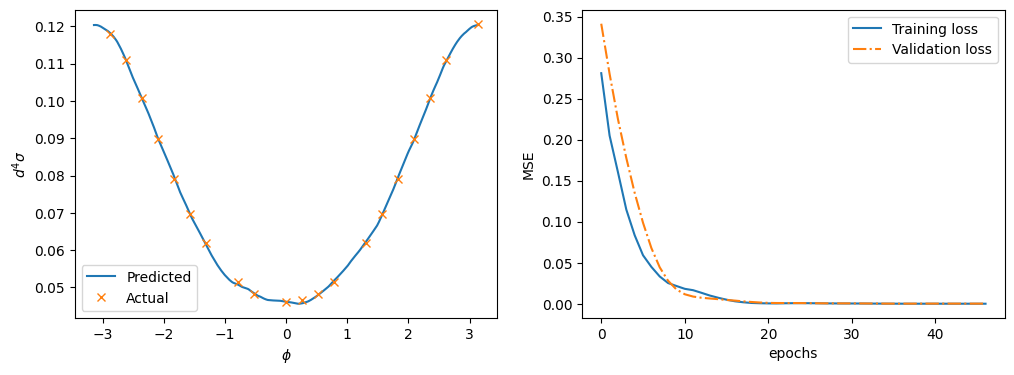

In [4]:
phi_array = np.pi-np.linspace(0, 2*np.pi, 1000)
test_phi = np.column_stack([np.cos(phi_array), np.sin(phi_array)])

predicted_dsig_1 = model1.predict(test_phi)

act_phi = np.arctan2(phi_train[:, 1].numpy(), phi_train[:, 0].numpy())
test_phi = np.arctan2(test_phi[:,1], test_phi[:,0])
act_dsig = dsig_scale.inverse_transform(dsig_train)
predicted_dsig_1 = dsig_scale.inverse_transform(predicted_dsig_1)

fig1, ax1 = plt.subplots(1, 2, figsize=(12, 4))

ax1[0].plot(test_phi, predicted_dsig_1, label='Predicted')
ax1[0].plot(act_phi, act_dsig, 'x', label='Actual')
ax1[0].set_xlabel(r'$\phi$')
ax1[0].set_ylabel(r'$d^{4}\sigma$')

ax1[1].plot(history1.history['loss'], label='Training loss')
ax1[1].plot(history1.history['val_loss'], '-.', label='Validation loss')
ax1[1].set_xlabel('epochs')
ax1[1].set_ylabel('MSE')

ax1[0].legend()
ax1[1].legend()

plt.show()

# Second Model

For a fixed set of input kinematics, predict the CFFs as a function of $\phi$ by using $d^4\sigma$ as the loss

In [5]:
def create_model2(lr=0.001):

    in_phi = keras.Input(shape=(2,), name='input_layer')
    hidden = keras.layers.Dense(100, activation='relu')(in_phi)
    hidden = keras.layers.Dense(100, activation='relu')(hidden)
    predicted_cffs = keras.layers.Dense(4, name='predicted_cff_layer')(hidden)
    
    # have to unscale phi, any tf operations within a graph must be run using a 'lambda' layer
    # in 'lambda phi:', phi is the argument to the function defined after the colon
    # phi[:,0:1] gets the first column for all batches and phi[:,1:2] gets the second column for all batches
    
    unscaled_phi = keras.layers.Lambda(lambda phi: tf.atan2(phi[:,1:2], phi[:,0:1]))(in_phi)

    # make the input kinematics for each batch. The tile function acts like tf.tile(..., multiples=[batch_size, 1])
    # it replicates the column vector batch_size times 

    kins_tiled = keras.layers.Lambda(
        lambda phi: tf.tile(
            tf.expand_dims(tf.constant([k, Q2, x, t], dtype=tf.float32), 0), # makes a column vector of 4 fixed kinematics
            multiples = [tf.shape(phi)[0], 1]
        ),
    )(unscaled_phi)

    # concatenate to get (batch_size, 5) kinematics matrix

    unscaled_kins = keras.layers.Concatenate()([kins_tiled, unscaled_phi])

    # pass the input kinematics to the BKM formalism to find predicted differential cross section

    predicted_dsig = keras.layers.Lambda(
        lambda args: diff_cross(args[0], args[1]),
        output_shape=(1,)
    )([unscaled_kins, predicted_cffs])

    # build and compile the model

    model = keras.Model(inputs=in_phi, outputs=predicted_dsig)
    model.compile(optimizer=keras.optimizers.Adam(lr), loss='mse')

    return model


modifyLR = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=20, min_lr=1e-5, mode='auto')

EarlyStop = keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=30)

model2 = create_model2()

history2 = model2.fit(phi_train, dsig_train, validation_data=(phi_val, dsig_val),
                     epochs=100, batch_size=10, callbacks=[modifyLR, EarlyStop])

Epoch 1/100
Tensor("kins:0", shape=(10, 5), dtype=float32)
1/2 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - loss: 0.2991Tensor("kins:0", shape=(None, 5), dtype=float32)
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - loss: 0.2327 - val_loss: 0.2374 - learning_rate: 0.0010
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.1372 - val_loss: 0.1974 - learning_rate: 0.0010
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 0.1163 - val_loss: 0.1617 - learning_rate: 0.0010
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.0811 - val_loss: 0.1292 - learning_rate: 0.0010
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0637 - val_loss: 0.1000 - learning_rate: 0.0010
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.0487 - val_loss: 0.0748 - learning_rate: 0.0010
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.0351 - val_loss: 0.0542 - learning_rate: 0.0010
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.0241 - val_loss: 0.0373 - learning_rate:

32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step


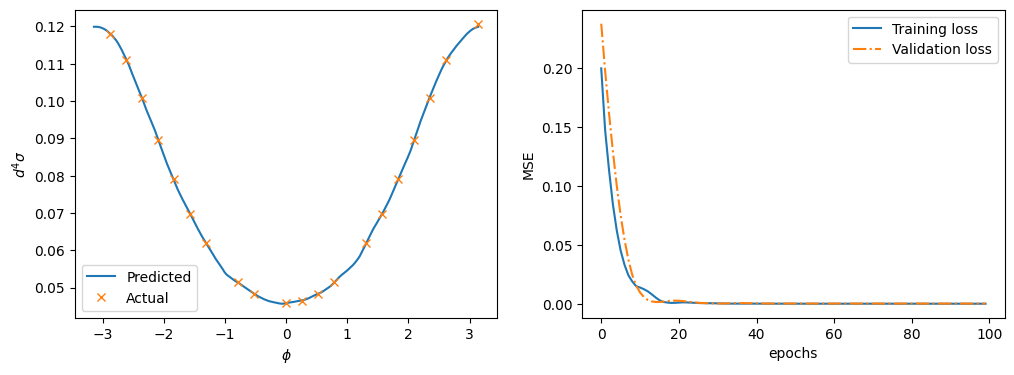

In [6]:
phi_array = np.pi-np.linspace(0, 2*np.pi, 1000)
test_phi = np.column_stack([np.cos(phi_array), np.sin(phi_array)])

predicted_dsig_2 = model2.predict(test_phi)

act_phi = np.arctan2(phi_train[:, 1].numpy(), phi_train[:, 0].numpy())
test_phi = np.arctan2(test_phi[:, 1], test_phi[:, 0])
act_dsig = dsig_scale.inverse_transform(dsig_train)
predicted_dsig_2 = dsig_scale.inverse_transform(predicted_dsig_2.reshape(-1, 1))

fig2, ax2 = plt.subplots(1, 2, figsize=(12, 4))

ax2[0].plot(test_phi, predicted_dsig_2, label='Predicted')
ax2[0].plot(act_phi, act_dsig, 'x', label='Actual')
ax2[0].set_xlabel(r'$\phi$')
ax2[0].set_ylabel(r'$d^{4}\sigma$')

ax2[1].plot(history2.history['loss'], label='Training loss')
ax2[1].plot(history2.history['val_loss'], '-.', label='Validation loss')
ax2[1].set_xlabel('epochs')
ax2[1].set_ylabel('MSE')

ax2[0].legend()
ax2[1].legend()

plt.show()

- Output and plot the CFF values

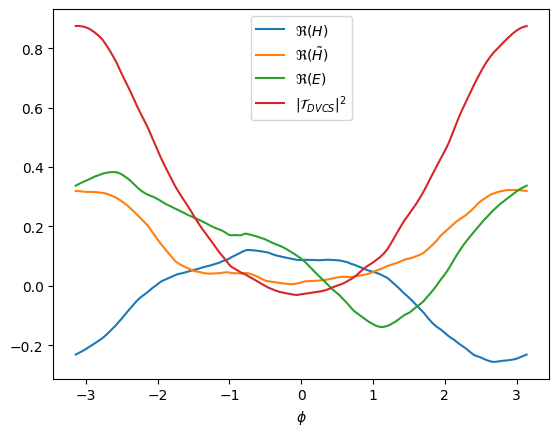

In [7]:
cff_model2 = tf.keras.Model(
    inputs = model2.inputs,
    outputs = model2.get_layer('predicted_cff_layer').output
)

phi_array = np.pi-np.linspace(0, 2*np.pi, 1000)
test_phi = np.column_stack([np.cos(phi_array), np.sin(phi_array)])

cffs = cff_model2(tf.convert_to_tensor(test_phi), training=False).numpy()

ReH, ReHt, ReE, DVCS = cffs[:, 0], cffs[:, 1], cffs[:,2], cffs[:,3]

plt.figure()
plt.plot(phi_array, ReH, label=r'$\Re(H)$')
plt.plot(phi_array, ReHt, label=r'$\Re(\tilde{H})$')
plt.plot(phi_array, ReE, label=r'$\Re(E)$')
plt.plot(phi_array, DVCS, label=r'$|\mathcal{T}_{DVCS}|^2$')

plt.xlabel(r'$\phi$')
plt.legend()

# Notes

- Model 2 found individual CFF values for each $\phi$. But this isn't really what we want. We want a fixed set of CFFs for a fixed set of kinematics.
- So techincally the model we build should output 1 set of CFF values which will give a best fit over **all** $\phi$ values.
- We can circumvent this by never passing $\phi$ and $k$ into out input layer.
- Since $\phi$ and $k$ don't go into the input layer, they don't really need to be scaled either.